In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12,5

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
df = pd.read_csv('../Data/HospitalityEmployees.csv',index_col=0, parse_dates=True)

In [4]:
df.index.freq='MS'

In [5]:
df.head()

,Employees
Date,
1990-01-01,1064.5
1990-02-01,1074.5
1990-03-01,1090.0
1990-04-01,1097.4
1990-05-01,1108.7


In [6]:
df.tail()

,Employees
Date,
2018-08-01,2019.1
2018-09-01,1992.5
2018-10-01,1984.3
2018-11-01,1990.1
2018-12-01,2000.2


# EDA

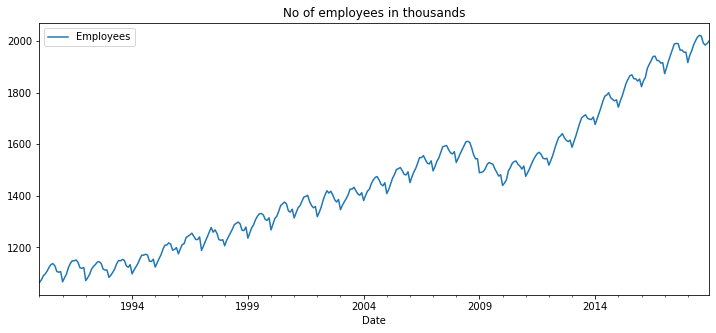

In [7]:
title = 'No of employees in thousands'
df.plot()
plt.title(title);

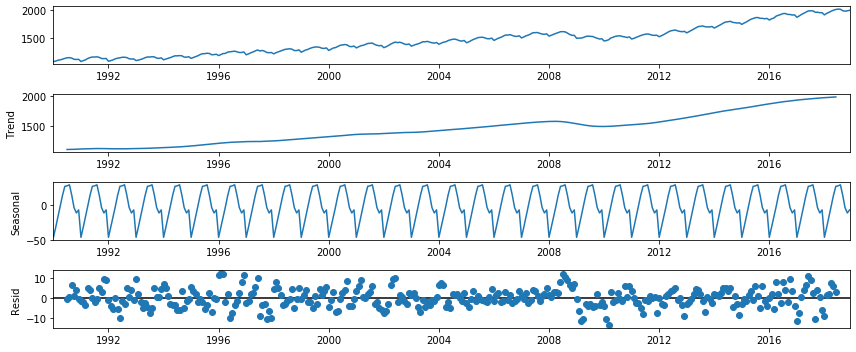

In [8]:
seasonal_decompose(df).plot();

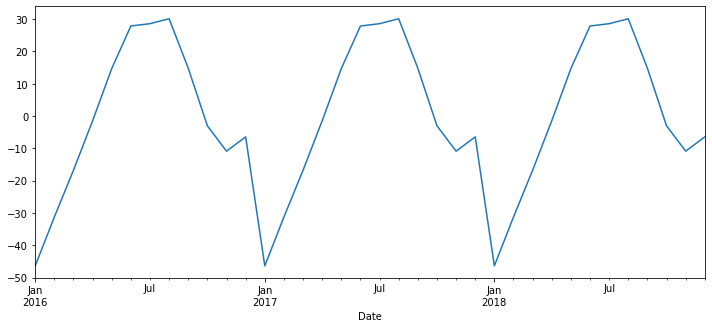

In [9]:
seasonal_decompose(df).seasonal.loc['2016':].plot();

# TRain Test Split

In [10]:
train = df.iloc[:-12]
test = df.iloc[-12:]

In [11]:
len(train)

336

# Scaled Data

In [12]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

In [14]:
n_input = 12
n_feature = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [15]:
X,y = generator[0]

In [16]:
X.shape, y.shape

((1, 12, 1), (1, 1))

# Model

In [17]:
model=Sequential()
model.add(LSTM(120, activation='relu', input_shape=(n_input, n_feature)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
model.fit_generator(generator, epochs=30)

Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
324/324 [==============================] - 4s 14ms/step - loss: 0.0095
Epoch 2/30
324/324 [==============================] - 5s 15ms/step - loss: 0.0014
Epoch 3/30
324/324 [==============================] - 5s 17ms/step - loss: 0.0022
Epoch 4/30
324/324 [==============================] - 5s 16ms/step - loss: 0.0018
Epoch 5/30
324/324 [==============================] - 5s 16ms/step - loss: 0.0012
Epoch 6/30
324/324 [==============================] - 5s 16ms/step - loss: 0.0013
Epoch 7/30
324/324 [==============================] - 5s 16ms/step - loss: 0.0011
Epoch 8/30
324/324 [==============================] - 5s 16ms/step - loss: 9.5138e-04
Epoch 9/30
324/324 [==============================] - 5s 16ms/step - loss: 0.0011
Epoch 10/30
324/324 [==============================] - 5s 16ms/step - loss: 0.0017
Epoch 11/30
324/324 [==============================] - 5s 16ms/step - loss: 0.001

In [19]:
pred_batch = scaled_train[-n_input:].reshape(1,n_input, n_feature)

In [20]:
model.predict(pred_batch)[0], scaled_test[0]

(array([0.96753615], dtype=float32), array([0.92001295]))

In [21]:
test_predictions = []
pred_batch = scaled_train[-n_input:]
current_batch = pred_batch.reshape(1,n_input,n_feature)

for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

In [22]:
test_predictions = scaler.inverse_transform(test_predictions)

In [23]:
test['Predictions'] = test_predictions

In [24]:
test.head()

,Employees,Predictions
Date,,
2018-01-01,1916.8,1960.825491
2018-02-01,1944.5,1969.114171
2018-03-01,1962.2,1975.899824
2018-04-01,1984.9,1979.246571
2018-05-01,2001.5,1978.004559


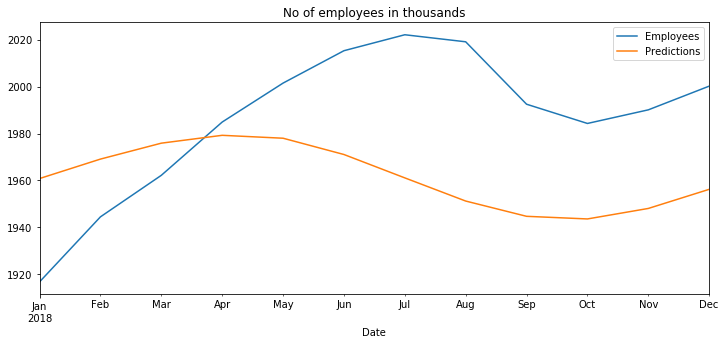

In [25]:
test.plot()
plt.title(title)
plt.legend();

In [26]:
from statsmodels.tools.eval_measures import rmse, mse

In [27]:
print('RMSE: {}'.format(rmse(test['Employees'], test['Predictions'])))
print('MSE: {}'.format(mse(test['Employees'], test['Predictions'])))

RMSE: 42.06745284217253
MSE: 1769.6705886284096
